In [2]:
import pickle

# Pfad zur gespeicherten .pkl-Datei
filename = "data/pickle/new_processed_documents.pkl"

# Laden der Liste aus der .pkl-Datei
with open(filename, "rb") as file:
    cleaned_documents = pickle.load(file)

# Ausgabe der bereinigten Dokumente mit den Token-Informationen
for i, doc in enumerate(cleaned_documents):
    print(f"Final Text for Document {i}:\n")
    final_text = " ".join([token_info[0] for token_info in doc])
    print(final_text)
    
    print(f"\nFinal Token Information for Document {i}:\n")
    for token_info in doc:
        print(f"Token: {token_info[0]}, POS: {token_info[1]}, Lemma: {token_info[2]}")
    print("\n" + "="*50 + "\n")

# Optional: Begrenze die Ausgabe auf die ersten 5 Dokumente, wenn es viele sind
    if i >= 4:
        break

Final Text for Document 0:

blaue altglascontainer saubere flaschen deckelgläser farben weiß blaues buntes glas grünglas geben aschen konservengläser scheiben restmüll trinkgläser porzellan keramik glühbirnen restmüll energiesparlampen wertstoffhöfe verschmutzte gläser restmüll standort öffentlichen sperrmüll plätzen frankfurter entsorgungs abfall trennen service gmbh fesservicecenter ecke töngesgasseschärfengässchen uhr uhr rgungsfachbetrie rrt trennen haus gehören abfallbehälter tonnen inhalt wertvoller rohstoff neuen produkten weiterverarbeitet graue restmülltonne gelbe tonne verpackungen grüne tonne papier pappe braune tonne bioabfälle graue tonne restlichen abfall restmüll gibt folgende entsorgungsangebote wertstoffe sichern altglascontainer flaschen deckelgläser nden öffentlichen plätzen altkleider container altkleider schuhe nden stadtteil öffentlichen plätzen feswertstoffhöfen schadstoffe abfälle gefährlichen stoffen farben spraydosen mitteln fesschadstoffmobil abgeben termine 

In [3]:
def split_into_chunks_with_metadata_v3(processed_doc, max_chunk_size=100, overlap_size=20):
    chunks = []
    current_chunk = []
    current_metadata = {'tokens': [], 'lemmas': [], 'pos_tags': []}
    current_length = 0
    
    for token_info in processed_doc:
        token, pos, lemma = token_info
        token_length = len(token.split())

        if current_length + token_length > max_chunk_size:
            if current_length > 0:
                chunks.append({
                    'text': " ".join([tok[0] for tok in current_chunk]),
                    'metadata': current_metadata
                })
            # Reset the chunk, keeping overlap
            current_chunk = current_chunk[-overlap_size:]
            current_metadata = {
                'tokens': current_metadata['tokens'][-overlap_size:],
                'lemmas': current_metadata['lemmas'][-overlap_size:],
                'pos_tags': current_metadata['pos_tags'][-overlap_size:]
            }
            current_length = sum(len(tok.split()) for tok in current_metadata['tokens'])
        
        current_chunk.append(token_info)
        current_metadata['tokens'].append(token)
        current_metadata['lemmas'].append(lemma)
        current_metadata['pos_tags'].append(pos)
        current_length += token_length
    
    if current_chunk:
        chunks.append({
            'text': " ".join([tok[0] for tok in current_chunk]),
            'metadata': current_metadata
        })

    return chunks

# Liste, die alle Chunks aus allen Dokumenten enthält
all_chunks = []

# Anwenden der Funktion auf alle Dokumente in der Liste
for i, processed_doc in enumerate(cleaned_documents):  # Hier wird 'cleaned_documents' verwendet
    chunks = split_into_chunks_with_metadata_v3(processed_doc, max_chunk_size=150, overlap_size=50)
    all_chunks.extend(chunks)  # Alle Chunks zur Hauptliste hinzufügen
    
    # Ausgabe der ersten paar Chunks des aktuellen Dokuments zur Überprüfung
    print(f"Document {i} Chunks:")
    for j, chunk in enumerate(chunks[:5]):
        print(f"Chunk {j+1} Text:\n{chunk['text']}\n")
        print(f"Chunk {j+1} Metadata:\n{chunk['metadata']}\n")
        print("="*50)
    print("\n" + "="*100 + "\n")

Document 0 Chunks:
Chunk 1 Text:
blaue altglascontainer saubere flaschen deckelgläser farben weiß blaues buntes glas grünglas geben aschen konservengläser scheiben restmüll trinkgläser porzellan keramik glühbirnen restmüll energiesparlampen wertstoffhöfe verschmutzte gläser restmüll standort öffentlichen sperrmüll plätzen frankfurter entsorgungs abfall trennen service gmbh fesservicecenter ecke töngesgasseschärfengässchen uhr uhr rgungsfachbetrie rrt trennen haus gehören abfallbehälter tonnen inhalt wertvoller rohstoff neuen produkten weiterverarbeitet graue restmülltonne gelbe tonne verpackungen grüne tonne papier pappe braune tonne bioabfälle graue tonne restlichen abfall restmüll gibt folgende entsorgungsangebote wertstoffe sichern altglascontainer flaschen deckelgläser nden öffentlichen plätzen altkleider container altkleider schuhe nden stadtteil öffentlichen plätzen feswertstoffhöfen schadstoffe abfälle gefährlichen stoffen farben spraydosen mitteln fesschadstoffmobil abgeben ter

In [4]:
import pickle
import os

def save_chunks_to_pickle(chunks, filename="data/pickle/new_chunks.pkl"):
    # Sicherstellen, dass der Ordner "data/pickle" existiert
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    # Speichern der Chunks in der angegebenen Datei
    with open(filename, "wb") as file:
        pickle.dump(chunks, file)
    
    print(f"Die Chunks wurden erfolgreich in '{filename}' gespeichert.")

# Beispielnutzung:
save_chunks_to_pickle(all_chunks, filename="data/pickle/new_chunks.pkl")

Die Chunks wurden erfolgreich in 'data/pickle/new_chunks.pkl' gespeichert.


In [48]:
from sentence_transformers import SentenceTransformer

def create_hybrid_embeddings(chunks, model_name='sentence-transformers/multi-qa-mpnet-base-dot-v1'):
    # Lade das vortrainierte Modell
    model = SentenceTransformer(model_name)
    
    # Listen für Embeddings und Metadaten
    embeddings = []
    metadatas = []
    
    # Durchlaufe jeden Chunk und erstelle Embeddings und Metadaten
    for chunk in chunks:
        # Konvertiere den Chunk in einen zusammenhängenden Text
        text = chunk['text']  # Nutze den Text des Chunks
        
        # Erstelle das Embedding für den Text
        embedding = model.encode(text)
        embeddings.append(embedding)
        
        # Extrahiere relevante Metadaten
        keywords = extract_keywords(chunk['metadata']['lemmas'])  # Nutze die Lemmata des Chunks
        metadatas.append({
            'text': text,
            'keywords': keywords,
            # Weitere Metadaten wie Kategorien oder Tags hinzufügen
        })
    
    print(f"Erstellte {len(embeddings)} Embeddings und Metadaten.")
    return embeddings, metadatas

def extract_keywords(lemmas):
    # Beispielhafte erweiterte Funktion zur Extraktion von Schlüsselwörtern
    keywords = set()
    relevant_terms = {'papier', 'glas', 'biomüll', 'restmüll', 'verpackung', 'altglascontainer', 'wertstoffhof'}
    
    for lemma in lemmas:
        if lemma.lower() in relevant_terms:
            keywords.add(lemma.lower())
    
    return list(keywords)

# Embeddings und Metadaten für alle gesammelten Chunks erstellen
embeddings, metadatas = create_hybrid_embeddings(all_chunks)

# Anzahl der Einträge, die Du anzeigen möchtest
num_examples = min(5, len(embeddings))  # Setzt num_examples auf 5 oder weniger, wenn nicht genug Embeddings vorhanden sind

# Ausgabe der ersten paar Embeddings und ihrer zugehörigen Metadaten
for i in range(num_examples):
    print(f"Chunk {i}:\n")
    print(f"Embedding: {embeddings[i][:10]}...")  # Zeigt nur die ersten 10 Werte des Embeddings
    print(f"Metadaten: {metadatas[i]}")
    print("\n" + "="*50 + "\n")

/Users/jan/Documents/GitHub/predictiv_chatbot/predictiv_chatbot/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Erstellte 8 Embeddings und Metadaten.
Chunk 0:

Embedding: [-0.07740387 -0.26504445 -0.23600419  0.32532585  0.03805728 -0.3623095
  0.29681903  0.23696484  0.13378248  0.17048605]...
Metadaten: {'text': 'blaue altglascontainer saubere flaschen deckelgläser farben weiß getrennt blaues buntes glas bitte grünglas geben aschen konservengläser scheiben trinkgläser blumenvasen restmüll keramik glühbirnen restmüll energiesparlampen wertstoffhöfe verschmutzte gläser restmüll standort öffentlichen sperrmüll plätzen frankfurter trennen service gmbh ecke töngesgasse schärfengässchen rgungsfachbetrie rtschafte eddn trennen haus gehören abfallbehälter tonnen inhalt produkten weiterverarbeitet graue restmülltonne gelbe tonne verpackungen grüne tonne papier pappe braune tonne bioabfälle graue tonne restlichen abfall folgende entsorgungsangebote wertstoffe sichern altglascontainer flaschen deckelgläser nden öffentlichen plätzen altkleider container altkleider schuhe nden stadtteil öffentlichen plätze

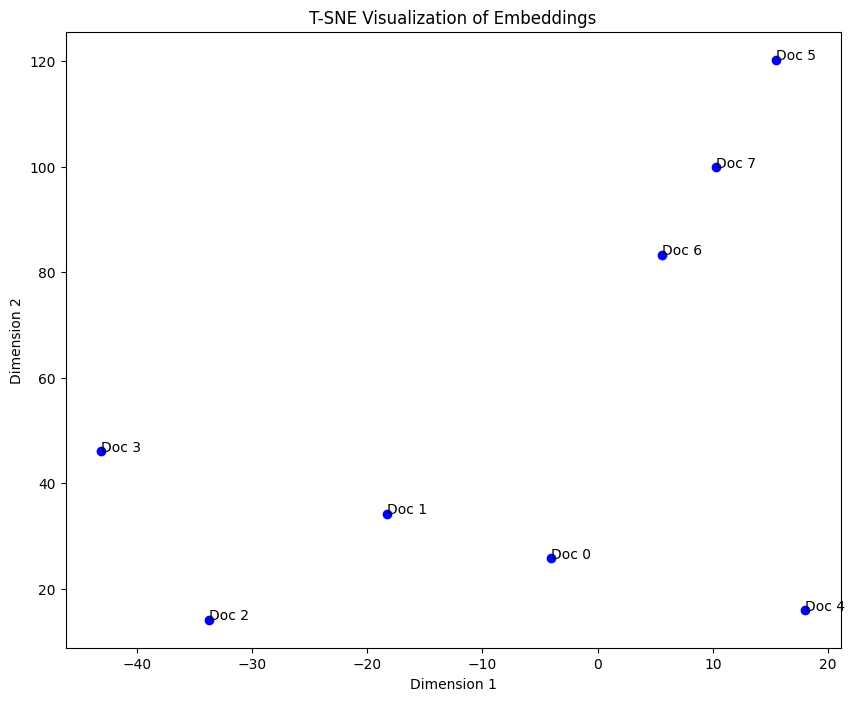

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings, labels=None):
    # Konvertiere die Liste der Embeddings in ein Numpy-Array
    embeddings_array = np.array(embeddings)
    
    # Setze die Perplexity auf einen Wert kleiner als die Anzahl der Dokumente
    tsne = TSNE(n_components=2, random_state=42, perplexity=2)
    reduced_embeddings = tsne.fit_transform(embeddings_array)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', label='Documents')
    
    if labels:
        for i, label in enumerate(labels):
            plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
    
    plt.title("T-SNE Visualization of Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Beispielnutzung:
labels = [f"Doc {i}" for i in range(len(embeddings))]
visualize_embeddings(embeddings, labels=labels)

In [50]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_embeddings(embeddings, labels=None, top_k=5):
    """
    Evaluiert die Qualität der Embeddings, indem sie die Kosinus-Ähnlichkeit zwischen ihnen berechnet und die nächsten Nachbarn überprüft.
    
    Args:
        embeddings (list of numpy arrays): Liste von Embeddings.
        labels (list of str): Optional, Liste von Labels, die den Embeddings entsprechen.
        top_k (int): Die Anzahl der nächsten Nachbarn, die für die Bewertung berücksichtigt werden.
    
    Returns:
        evaluation_results (dict): Ein Dictionary mit den nächsten Nachbarn für jedes Dokument und deren Ähnlichkeitswerten.
    """
    # Konvertiere die Liste der Embeddings in ein Numpy-Array
    embeddings_array = np.array(embeddings)
    
    # Berechne die Kosinus-Ähnlichkeit zwischen allen Embeddings
    similarity_matrix = cosine_similarity(embeddings_array)
    
    evaluation_results = {}
    
    for i in range(len(embeddings)):
        # Sortiere die Ähnlichkeiten in absteigender Reihenfolge und finde die Top-k nächsten Nachbarn
        similar_indices = np.argsort(-similarity_matrix[i])[1:top_k+1]
        similar_scores = similarity_matrix[i][similar_indices]
        
        # Speichere die Ergebnisse in einem Dictionary
        if labels:
            similar_docs = [labels[j] for j in similar_indices]
        else:
            similar_docs = similar_indices.tolist()
        
        evaluation_results[labels[i] if labels else i] = {
            "similar_docs": similar_docs,
            "similar_scores": similar_scores
        }
    
    return evaluation_results

# Beispielnutzung:
evaluation_results = evaluate_embeddings(embeddings, labels=labels)

# Ausgabe der Ergebnisse für die ersten paar Dokumente
for doc, result in list(evaluation_results.items())[:5]:
    print(f"Document: {doc}")
    print(f"Similar Documents: {result['similar_docs']}")
    print(f"Similarity Scores: {result['similar_scores']}\n")
    print("="*50)

Document: Doc 0
Similar Documents: ['Doc 1', 'Doc 2', 'Doc 6', 'Doc 4', 'Doc 3']
Similarity Scores: [0.8637098  0.7803474  0.7716971  0.7615002  0.71413517]

Document: Doc 1
Similar Documents: ['Doc 0', 'Doc 6', 'Doc 2', 'Doc 7', 'Doc 3']
Similarity Scores: [0.8637098  0.8202685  0.7963257  0.7779136  0.75504327]

Document: Doc 2
Similar Documents: ['Doc 1', 'Doc 0', 'Doc 3', 'Doc 6', 'Doc 7']
Similarity Scores: [0.7963257 0.7803474 0.7478682 0.6618259 0.6209267]

Document: Doc 3
Similar Documents: ['Doc 1', 'Doc 2', 'Doc 7', 'Doc 0', 'Doc 6']
Similarity Scores: [0.75504327 0.7478682  0.73463416 0.71413517 0.70467347]

Document: Doc 4
Similar Documents: ['Doc 0', 'Doc 6', 'Doc 1', 'Doc 7', 'Doc 2']
Similarity Scores: [0.7615002  0.6429783  0.62931776 0.6285146  0.608896  ]



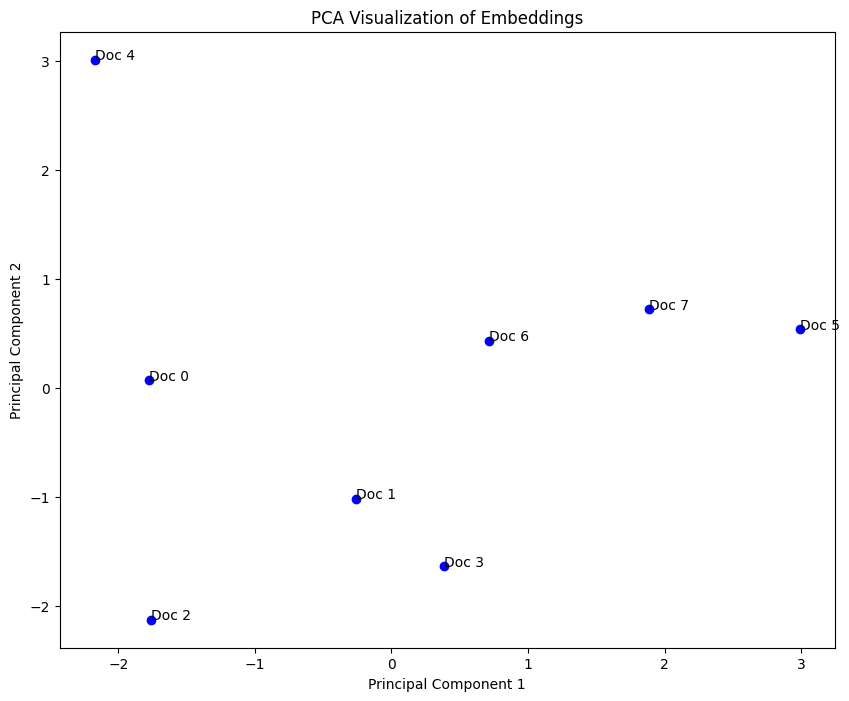

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_embeddings_pca(embeddings, labels=None, n_components=2):
    # Konvertiere die Liste der Embeddings in ein Numpy-Array
    embeddings_array = np.array(embeddings)
    
    # Führe PCA durch
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings_array)
    
    # Erstelle ein Streudiagramm
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', label='Documents')
    
    if labels:
        for i, label in enumerate(labels):
            plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
    
    plt.title("PCA Visualization of Embeddings")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

# Beispielnutzung:
labels = [f"Doc {i}" for i in range(len(embeddings))]
visualize_embeddings_pca(embeddings, labels=labels)